# Statistics of water data

USGS water data are available at https://waterdata.usgs.gov/nwis

## 1. Acquire data

Use web interface of web service to download historical water flow or gauge data. Try to find a site with as long data set as possible, e.g. site 01589440

    curl "https://nwis.waterdata.usgs.gov/usa/nwis/uv/?cb_00060=on&format=rdb&site_no=01589440&period=&begin_date=1997-01-01&end_date=2018-02-08" > water.txt
    
    "cURL is a tool to transfer data from or to a server, using one of the supported protocols (DICT, FILE, FTP, FTPS, GOPHER, HTTP, HTTPS, IMAP, IMAPS, LDAP, LDAPS, POP3, POP3S, RTMP, RTSP, SCP, SFTP, SMB, SMBS, SMTP, SMTPS, TELNET and TFTP). The command is designed to work without user interaction."

for the following 4 site(s) are contained in water.txt-old
*    USGS 01585500 CRANBERRY BRANCH NEAR WESTMINSTER, MD
*    USGS 01589440 JONES FALLS AT SORRENTO, MD
*    USGS 01639000 MONOCACY RIVER AT BRIDGEPORT, MD
*    USGS 01639500 BIG PIPE CREEK AT BRUCEVILLE, MD

USGS 01585500 CRANBERRY BRANCH has Ice around 2018-01

These sites are located around Baltimore

### USGS historical data
https://waterdata.usgs.gov/nwis/uv/?referred_module=sw

### USGS parameter codes

https://help.waterdata.usgs.gov/codes-and-parameters/parameters

### REST docs
https://waterservices.usgs.gov/rest/Site-Service.html

### USGS tutorial
https://help.waterdata.usgs.gov/tutorials

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas as pd
#from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from scipy.optimize import curve_fit
from scipy import signal
from scipy import stats
import math as math
import pycurl
from io import BytesIO

Retrieve data

In [3]:
def get_site_url( site_number='01589440', date_from="2008-01-01", date_to="2017-12-31" ): 
    # input: site_number is a string
    # the parameters in the url can have different formats. cb_00065 is the same as parameterCd=00060
    
    #url = 'https://nwis.waterdata.usgs.gov/nwis/uv/?cb_00065=on&format=rdb&site_no=%s&period=&begin_date=%s\
#&end_date=%s&siteStatus=all'%(site_number, date_from, date_to)

    url = 'https://nwis.waterdata.usgs.gov/nwis/uv/?parameterCd=00060,00065&format=rdb&site_no=%s&period=&begin_date=%s\
&end_date=%s&siteStatus=all'%(site_number, date_from, date_to)
    return url

def download_data_from_url( url, savename='test.csv' ):
    ''' 
    One can download data with a different method that supports resume. If data is two large then it takes
    lot of time and the connection to the server might be interrupted.
    '''
    
    buffer = BytesIO()
    c = pycurl.Curl()
    c.setopt(c.URL, url)
    c.setopt(c.WRITEDATA, buffer)
    c.perform()
    c.close()

    body = buffer.getvalue() # Body is a byte string.
    with open( savename, 'w' ) as output:
        output.write( body.decode('utf-8')) # We have to know the encoding in order to print it to a text file

### Let's download last year's data for site 01589440

In [4]:
site_number = '01589440'
date_from = "2008-01-01"
date_to = "2017-12-31"
url = get_site_url(site_number, date_from, date_to)
download_data_from_url(url, "%s.csv"%site_number)

In [5]:
!head -n 35 01589440.csv

# ---------------------------------- WARNING ----------------------------------------
# Some of the data that you have obtained from this U.S. Geological Survey database
# may not have received Director's approval. Any such data values are qualified
# as provisional and are subject to revision. Provisional data are released on the
# condition that neither the USGS nor the United States Government may be held liable
# for any damages resulting from its use.
#
# Additional info: https://help.waterdata.usgs.gov/policies/provisional-data-statement
#
# File-format description:  https://help.waterdata.usgs.gov/faq/about-tab-delimited-output
# Automated-retrieval info: https://help.waterdata.usgs.gov/faq/automated-retrievals
#
# Contact:   gs-w_support_nwisweb@usgs.gov
# retrieved: 2019-04-25 18:37:47 EDT       (nadww02)
#
# Data for the following 1 site(s) are contained in this file
#    USGS 01589440 JONES FALLS AT SORRENTO, MD
# -------------------------------------------------------------

### It is clear that some rows need to be skipped when reading the datafile

In [64]:
data = pd.read_csv("01585500.csv", sep='\t', comment='#', header=0, skiprows=[33], parse_dates=[2])
data = pd.read_csv("01589440.csv", sep='\t', comment='#', header=0, skiprows=[31], parse_dates=[2])


#### Convert date into Unix timestamp

In [75]:
#data.head()
data = data.drop(data.index[0])


In [78]:
#data['ts'] = ata['datetime']
data.head()


,agency_cd,site_no,datetime,tz_cd,69744_00060,69744_00060_cd,69745_00065,69745_00065_cd
1,USGS,01589440,2008-01-01 00:15,EST,18.5,A,3.49,A
2,USGS,01589440,2008-01-01 00:30,EST,18.5,A,3.49,A
3,USGS,01589440,2008-01-01 00:45,EST,18.5,A,3.49,A
4,USGS,01589440,2008-01-01 01:00,EST,18.5,A,3.49,A
5,USGS,01589440,2008-01-01 01:15,EST,18.0,A,3.48,A


In [79]:
data['ts'] = data.datetime.map(lambda x: x.timestamp())

AttributeError: 'str' object has no attribute 'timestamp'

### Plot two quantities with pandas on different scales

For that we rename the two columns with data

In [80]:
data = data.rename(index=str, columns={"69744_00060": "Discharge"})
data = data.rename(index=str, columns={"69745_00065": "GageHeight"})

In [82]:
data.head()

,agency_cd,site_no,datetime,tz_cd,Discharge,69744_00060_cd,GageHeight,69745_00065_cd
1,USGS,01589440,2008-01-01 00:15,EST,18.5,A,3.49,A
2,USGS,01589440,2008-01-01 00:30,EST,18.5,A,3.49,A
3,USGS,01589440,2008-01-01 00:45,EST,18.5,A,3.49,A
4,USGS,01589440,2008-01-01 01:00,EST,18.5,A,3.49,A
5,USGS,01589440,2008-01-01 01:15,EST,18.0,A,3.48,A


TypeError: Empty 'DataFrame': no numeric data to plot

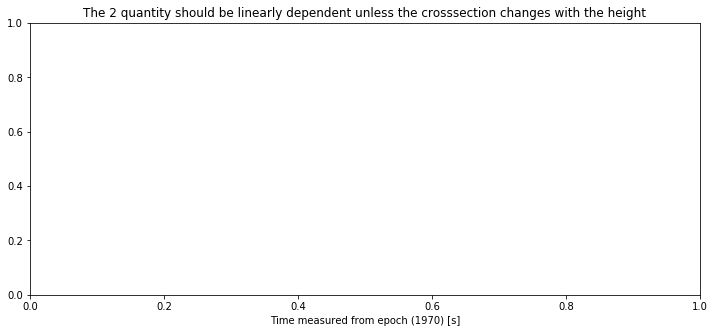

In [84]:
plt.figure(figsize=(12,5))
plt.title('The 2 quantity should be linearly dependent unless the crosssection changes with the height')
plt.xlabel('Time measured from epoch (1970) [s]')

ax1 = data['Discharge'].plot(color='blue', grid=True, label='Discharge')
ax1.set_ylabel('Discharge [feet$^3$]')
# ax2 = data.GageHeight.plot(color='red', grid=True, secondary_y=True, label='Gage Height')
# ax2.set_ylabel('Gage height [feet]')
# h1, l1 = ax1.get_legend_handles_labels()
# h2, l2 = ax2.get_legend_handles_labels()
# plt.legend(h1+h2, l1+l2, loc=2)
plt.show()

### Clean the data

In [15]:
# Now Download the data for another river
site_number = '01585500'
date_from = "2017-10-01"
date_to = "2018-09-30"
url = get_site_url(site_number, date_from, date_to)
download_data_from_url(url, "%s-ice.csv"%site_number)

In [16]:
dataice = pd.read_csv("01585500-ice.csv", sep='\t', comment='#', header=0, skiprows=[29], parse_dates=[2])
dataice = dataice.rename(index=str, columns={"69679_00060": "Discharge"})
dataice = dataice.rename(index=str, columns={"69680_00065": "GageHeight"})
dataice['ts'] = dataice.datetime.map(lambda x: x.timestamp())
dataice.head()

,agency_cd,site_no,datetime,tz_cd,Discharge,69679_00060_cd,GageHeight,69680_00065_cd,ts
0,USGS,1585500,2017-10-01 00:00:00,EDT,0.30,A,1.24,A,1.506816e+09
1,USGS,1585500,2017-10-01 00:15:00,EDT,0.30,A,1.24,A,1.506817e+09
2,USGS,1585500,2017-10-01 00:30:00,EDT,0.30,A,1.24,A,1.506818e+09
3,USGS,1585500,2017-10-01 00:45:00,EDT,0.30,A,1.24,A,1.506819e+09
4,USGS,1585500,2017-10-01 01:00:00,EDT,0.30,A,1.24,A,1.506820e+09


### Now if we try to plot it we encounter some problems
The error message is a bit misleading

In [85]:
dataice.plot('ts','Discharge')

NameError: name 'dataice' is not defined

#### Let's Put a mask on the values which belongs to the frozen state 'Ice' (and there is another state labelled as 'Bkw')

In [18]:
dataice.head()

,agency_cd,site_no,datetime,tz_cd,Discharge,69679_00060_cd,GageHeight,69680_00065_cd,ts
0,USGS,1585500,2017-10-01 00:00:00,EDT,0.30,A,1.24,A,1.506816e+09
1,USGS,1585500,2017-10-01 00:15:00,EDT,0.30,A,1.24,A,1.506817e+09
2,USGS,1585500,2017-10-01 00:30:00,EDT,0.30,A,1.24,A,1.506818e+09
3,USGS,1585500,2017-10-01 00:45:00,EDT,0.30,A,1.24,A,1.506819e+09
4,USGS,1585500,2017-10-01 01:00:00,EDT,0.30,A,1.24,A,1.506820e+09


In [19]:
def ice(x):
    if x == 'Ice':
        return -1
    elif x == 'Bkw':
        return -1
    else:
        return x

dataice.Discharge = np.array(dataice.Discharge.map(ice), dtype=float)

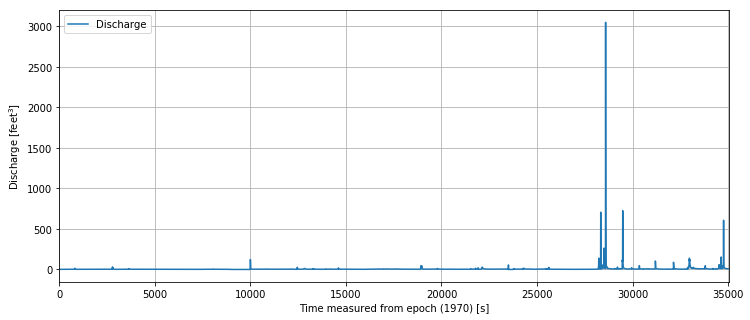

In [20]:
plt.figure(figsize=(12,5))

plt.xlabel('Time measured from epoch (1970) [s]')

ax1 = dataice.Discharge.plot(x='datetime', grid=True, label='Discharge')

ax1.set_ylabel('Discharge [feet$^3$]')
h1, l1 = ax1.get_legend_handles_labels()

plt.legend(h1, l1, loc=2)
plt.show()

Distribution of water level values

In [35]:
lvl = data['Discharge']

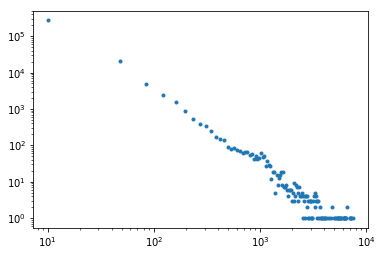

In [36]:
lvlhist, bins = np.histogram(lvl[lvl>10], bins=200)
plot(bins[:-1], lvlhist, ".")
xscale('log')
yscale('log')

Smooth data with a Hamming window to get rid of plateaus

In [37]:
w = np.hamming(9)
smlvl = np.convolve(w/w.sum(),lvl,mode='same')

In [38]:
#Distributions
def weibull(x, b, e):
    return b/e*( x/e )**(b-1) * exp( - (x/e )**b )
    
def weibullplot(x, b, e):
    w = weibull(x, b, e)
    plot(x, w)

In [39]:
slvlhist, bins = np.histogram(smlvl[smlvl>0], bins=200)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


In [40]:
tx=linspace(0.1,2.5,40)
interact(weibull, x=fixed(tx), b=(0.1,3.0,0.1), e=fixed(1));

interactive(children=(FloatSlider(value=1.5000000000000002, description='b', max=3.0, min=0.1), Output()), _dom_classes=('widget-interact',))

In [41]:
from scipy.optimize import curve_fit 

In [42]:
def lin(x,a,b):
    return a*x+b

In [43]:
popt,pcov = curve_fit(lin, log(range(1,len(lvlhist[lvlhist>10])+1)), log(lvlhist[lvlhist>10]))

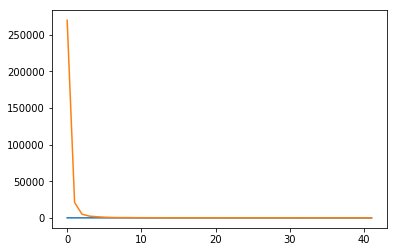

In [44]:
rx=range(len(lvlhist[lvlhist>10]))
plot(rx,lin(rx,popt[0],popt[1]))
plot(rx,lvlhist[lvlhist>10])


In [45]:
popt,pcov = curve_fit(weibull, bins[:-1][slvlhist>0], log(slvlhist[slvlhist>0]))

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in power
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in multiply
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in multiply
  This is separate from the ipykernel package so we can avoid doing imports until


In [46]:
popt

array([91.4756875 ,  2.89341327])

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in power
  This is separate from the ipykernel package so we can avoid doing imports until


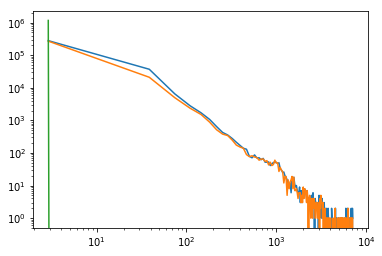

In [47]:
plot(bins[:-1], slvlhist)
plot(bins[:-1], lvlhist)
plot(bins[:-1], 100000*weibull(bins[:-1], popt[0], popt[1]))
xscale('log')
yscale('log')

Find local maxima

Consider it a rain if derivative is sufficiently steep (3)

In [48]:
maxlvl = np.r_[True, smlvl[1:] > smlvl[:-1]  + 0.2] & np.r_[smlvl[:-1] > smlvl[1:], True]
np.sum(maxlvl)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


568

In [51]:
tm = data['ts'].astype()

In [54]:
data.head()

,agency_cd,site_no,datetime,tz_cd,Discharge,69744_00060_cd,GageHeight,69745_00065_cd,ts
0,USGS,1589440,2008-01-01 00:00:00,EST,18.5,A,3.49,A,1.199146e+09
1,USGS,1589440,2008-01-01 00:15:00,EST,18.5,A,3.49,A,1.199146e+09
2,USGS,1589440,2008-01-01 00:30:00,EST,18.5,A,3.49,A,1.199147e+09
3,USGS,1589440,2008-01-01 00:45:00,EST,18.5,A,3.49,A,1.199148e+09
4,USGS,1589440,2008-01-01 01:00:00,EST,18.5,A,3.49,A,1.199149e+09


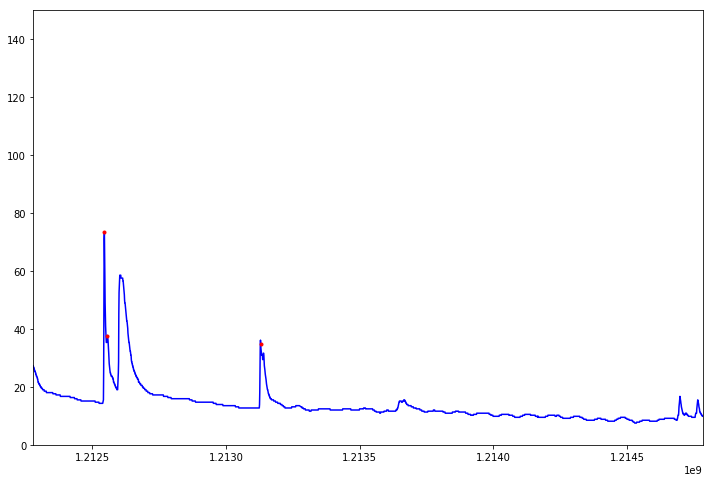

In [55]:
figsize(12,8)
xlim(pd.Timestamp(2008,6,1).timestamp(), pd.Timestamp(2008,6,30).timestamp())
ylim(0,150)
plot(tm,lvl, 'b-', ms=0.5)
plot(tm[maxlvl], lvl[maxlvl], 'r.')

Distribution of maxima

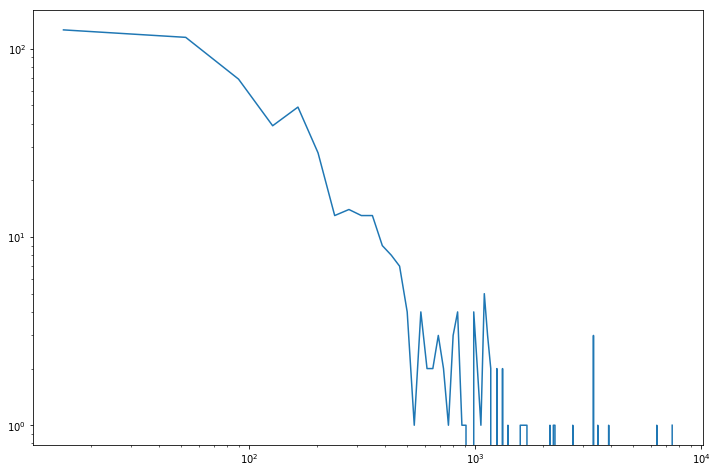

In [56]:
maxhist, bins = np.histogram(lvl[maxlvl], bins=200)
plot(bins[:-1], maxhist)
xscale('log')
yscale('log')

Distribution of time intervals between rains

In [57]:
np.diff(tm[maxlvl])

array([2.7369e+06, 1.0080e+06, 1.9800e+04, 1.7676e+06, 1.0800e+04,
       9.0000e+03, 2.1780e+05, 9.9000e+03, 1.0584e+06, 1.2969e+06,
       6.8130e+05, 7.3710e+05, 2.4300e+04, 4.8600e+04, 4.8684e+05,
       1.4226e+05, 9.0270e+05, 2.6820e+05, 1.9692e+06, 1.0800e+04,
       5.7420e+05, 2.8557e+06, 8.6760e+05, 9.9000e+03, 5.7870e+05,
       1.0800e+04, 2.5830e+06, 1.1700e+04, 8.2800e+04, 1.2600e+04,
       5.6520e+05, 6.3000e+03, 5.4990e+05, 6.3000e+03, 1.2384e+06,
       2.7000e+04, 9.9000e+03, 2.6370e+05, 9.0000e+03, 2.1384e+06,
       7.2000e+03, 1.6308e+06, 1.3500e+05, 9.9000e+03, 3.7800e+04,
       1.2924e+06, 4.0500e+04, 8.3070e+05, 1.0080e+05, 4.4190e+05,
       3.6279e+06, 2.9574e+06, 2.0304e+06, 1.2870e+05, 1.2690e+05,
       3.7980e+05, 9.9000e+03, 1.8000e+04, 6.9390e+05, 3.5640e+05,
       4.2930e+05, 3.8700e+04, 9.2520e+05, 2.5380e+05, 8.9190e+05,
       1.6551e+06, 6.8400e+04, 7.2000e+03, 4.9140e+05, 8.1000e+03,
       1.0260e+05, 6.3180e+05, 6.3000e+03, 2.0700e+04, 1.4850e

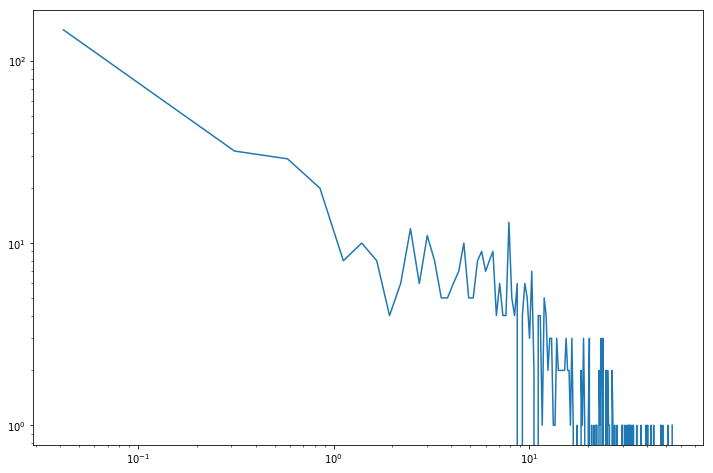

In [58]:
tmhist, bins = np.histogram(np.diff(tm[maxlvl])/3600./24., bins=200)
plot(bins[:-1], tmhist)
xscale('log')
yscale('log')

Maximum water level in a rolling window of 1 year

The solution is a bit simplified and assumes that measurement are always available and are equally spaced.

Given a 15 min sampling time, a month is a window of 24 × 4 × 30 = 2880 samples

This could be fitted with the Weibull distribution

In [59]:
wl = 2880
l = int(lvl.shape[0]/wl)
rollmaxlvl = np.empty(l)
for i in range(0, l):
    rollmaxlvl[i] = np.max(lvl[i*wl:(i+1)*wl])
    
rollmaxlvl.shape

(120,)

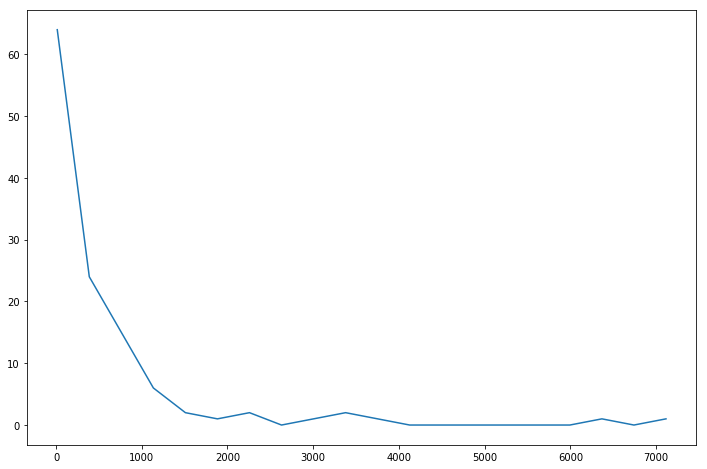

In [60]:
rollmaxhist, bins = np.histogram(rollmaxlvl[rollmaxlvl>0], bins=20)
plot(bins[:-1], rollmaxhist)

Times it rained in a month

In [61]:
wl = 5000
l = int(lvl.shape[0]/wl)
raincount = np.empty(l)
for i in range(0, l):
    raincount[i] = np.sum(maxlvl[i*wl:(i+1)*wl])
    
raincount.shape

(69,)

In [62]:
raincount

array([ 4.,  8.,  9.,  4., 10.,  7.,  9.,  2., 10., 13.,  8., 10.,  4.,
        4.,  4.,  2.,  7., 12.,  3., 10.,  1.,  7., 15.,  9., 18., 17.,
        9.,  4.,  3.,  4., 12., 12., 13.,  3.,  6.,  6.,  9., 16., 10.,
       11.,  3.,  6., 11., 11., 19.,  9.,  7.,  9.,  9.,  7.,  4., 19.,
       10.,  6.,  4.,  4.,  6.,  7.,  9., 15.,  7.,  6.,  2.,  0.,  9.,
       10., 20., 10.,  4.])

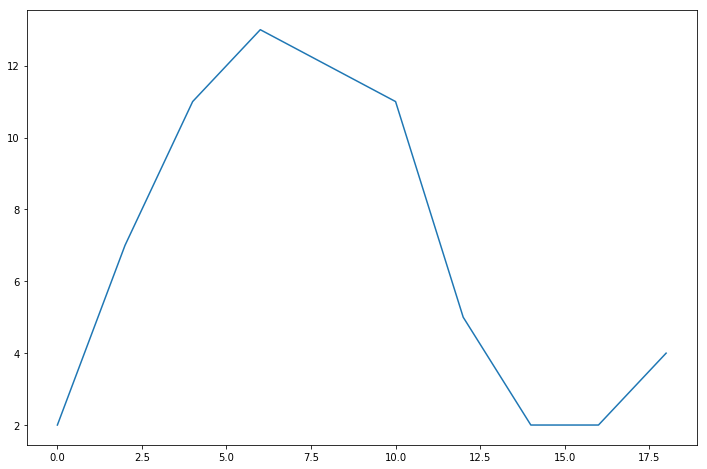

In [63]:
rainhist, bins = np.histogram(raincount, 10)
plot(bins[:-1], rainhist)